# Data Science for Drug Discovery
### _Can we use machine learning to help discover new drugs that target COVID-19?_

In this presentation, we have used data from the Covid [Moonshot](https://postera.ai/moonshot) project to develop machine learning models for the virtual screening of ligands to inhibit SARS-CoV-2 main protease.


## Introduction to SARS-CoV-2 M<sup>pro</sup>

SARS-CoV-2 is a positive-sense, single-stranded RNA coronavirus with a large (30,000 base) genome. This genome acts just like a messenger RNA when it infects a cell, and directs the synthesis of two long polyproteins that include the machinery that the virus needs to replicate new viruses. These proteins include a replication/transcription complex that makes more RNA, several structural proteins that construct new virions, and two proteases. The proteases play essential roles in cutting the polyproteins into all of these functional pieces.


### Main Protease

The main protease of coronavirus makes most of these cuts. The one shown here (PDB entry 6lu7) is from the SARS-CoV-2 (2019-nCoV) coronavirus that is currently posing dangers in Wuhan. It is a dimer of two identical subunits that together form two active sites. This structure has a peptide-like inhibitor bound in the active site.

![Coronavirus Protease, with Inhibitor](Coronavirus_Proteases.jpg "Coronavirus Protease, with Inhibitor")


## COVID Moonshot project

* Research to develop a globally accessible antiviral pill for COVID
* Provides activity data for a range of small molecule targets

![Moonshot Webpage](moonshot.png)


In [3]:
# Relevant imports (Global)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import rdkit.Chem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw



In [4]:
# Relevant imports (Local)

import sys
sys.path.append("..")

import importer
import analyser
from analysis_methods import AnalysisMethods

## Importing the Data
### SQL Methods

* Collect binding data from COVID Moonshot project
* Create and populate new database 
* Construct a relational database to enable querying of the data

In [5]:
# Creates a relational database from the binding data

# Methods here do not use full input sanitisation and may be vulnerable to SQL injection attacks, however
# this script is designed for internal use only.

import sqlite3
from sqlite3 import Error


def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    return conn

def delete_molecule(conn, id):
    """
    Delete a molecule by molecule id
    :param conn:  Connection to the SQLite database
    :param id: id of the molecule
    :return:
    """
    sql = 'DELETE FROM assays WHERE id=?'
    cur = conn.cursor()
    cur.execute(sql, (id,))
    conn.commit()

In [6]:
def print_head(conn, table):
    """
    Print head of table (internal conversion to csv)
    :param conn:  Connection to the SQLite database
    :param table: Name of table within open database
    :return:
    """
    sql = "SELECT * from {}".format(table)  # Not secure - see header
    df = pd.read_sql_query(sql, conn)
    print(df.head())

def find_columns(conn, table):
    """
    Return columns of table (internal conversion to csv)
    :param conn:  Connection to the SQLite database
    :param table: Name of table within open database
    :return:
    """
    sql = "SELECT * from {}".format(table)  # Not secure - see header
    df = pd.read_sql_query(sql, conn)
    return df.columns.values

In [7]:
def connect_tables(conn, table_1, key_1, table_2):
    """
    Connect two tables within database - Adds the primary
    key in table_1 as foreign key in table 2. This requires
    creation of a new table in sqlite.

    :param conn:  Connection to the SQLite database
    :param table_1: Name of parent table
    :param key_1:   Name of column in table_1 to use as foreign key
    :param table_2: Name of child table
    :return:
    """
    cur = conn.cursor()
    cur.execute("PRAGMA foreign_keys = off;")  
    cur.execute("BEGIN TRANSACTION;")

    # Rename table
    cur.execute("DROP TABLE IF EXISTS _old_t") # for protection in case clean up not reached
    rename_sql = "ALTER TABLE {} RENAME TO {};".format(table_2, '_old_t')
    cur.execute(rename_sql)

    # Create new table with foreign key
    table_2_titles = ", ".join(find_columns(conn, '_old_t'))
    table_2_titles += ", {} VARCHAR".format(key_1)  # For foreign key column
    create_sql = ("CREATE TABLE {2} ({3}, CONSTRAINT FK_{0} FOREIGN KEY ({0}) REFERENCES {1} ({0}));"
        .format(key_1, table_1, table_2, table_2_titles))
    cur.execute(create_sql)

    # Add foreign key data to import table
    add_sql_a = "ALTER TABLE _old_t ADD {};".format(key_1)
    add_sql_b = "INSERT INTO _old_t ({0}) SELECT {0} FROM {1};".format(key_1, table_1)
    cur.execute(add_sql_a)
    cur.execute(add_sql_b)
    
    # Copy data into new table
    insert_sql = "INSERT INTO {} SELECT * FROM _old_t;".format(table_2)
    cur.execute(insert_sql)

    # Delete temporary table
    cur.execute("DROP TABLE IF EXISTS _old_t")

    conn.commit()
    cur.execute("PRAGMA foreign_keys=on;")
    return table_2

In [8]:
def main():
    input_data = "data/activity_data.csv"
    database = "sqlite/db/activity.db"

    # Read in data
    df = pd.read_csv(input_data)

    # Create a database connection
    conn = create_connection(database)

    with conn:
        # Create assays table
        df.drop(['SMILES'], axis = 1).to_sql('assays', conn, if_exists='replace', index=False)

        # Create compounds table
        df['SMILES'].to_sql('compounds', conn, if_exists='replace', index=False)
        connect_tables(conn, 'compounds', 'SMILES', 'assays')
        
        # Test output from database
        print_head(conn, 'assays')

    # Close connection if still open (fail-safe)
    conn.close

# if __name__ == '__main__':
#     main()

### Pandas Dataframe
This 

In [9]:
# Import the data into a pandas csv

import pandas as pd

def import_csv(filename):
    """Imports the csv file at a given path
    
    :param filename: Path and name of file to import
    :type filename: str
    :return: Dataframe of csv file
    """
    return pd.read_csv(filename, sep=',')

def record_assays(df):
    """Removes SMILES data to create assay dataframe, where
    each row corresponds to a different assay (and a different 
    molecule)
    
    :param df: Dataframe of input data
    :type df: Pandas Dataframe
    :return: Dataframe of assay data
    """
    #Still need to sort this data
    return df.drop(['SMILES'], axis = 1)


In [10]:
def record_compounds(df):
    """Isolate SMILES data to create compound dataframe
    
    :param df: Dataframe of input data
    :type df: Pandas Dataframe
    :return: Dataframe of assay data
    """
    series =  df['SMILES']
    return series.to_frame()

def import_data(filename):
    """Imports the data at a given path
    
    :param filename: Path and name of file to import
    :type filename: str
    :return: Dataframes of assays and compounds
    :return type: pandas Dataframe
    """
    # Read in data
    df = import_csv(filename)

    df_assay = record_assays(df)
    df_compounds = record_compounds(df)
    
    return df_assay, df_compounds

## Structuring the Data

In [11]:
df_assay, df_compounds = importer.import_data('../data/activity_data.csv')
df_compounds = pd.DataFrame(df_compounds)

## Populate molecule data from RDKit

In [12]:
#Calculate and populate df with Lipinski parameters

H_acc_list, H_don_list, MW_list, logP_list = [], [], [], []
for i in df_compounds['SMILES']:
    m = Chem.MolFromSmiles(i)
    H_acc_list.append(Descriptors.NumHAcceptors(m))
    H_don_list.append(Descriptors.NumHDonors(m))
    MW_list.append(Descriptors.ExactMolWt(m))
    logP_list.append(Descriptors.MolLogP(m))

df_compounds['H_acceptors'] = H_acc_list
df_compounds['H_donors'] = H_don_list
df_compounds['MW'] = MW_list
df_compounds['LogP'] = logP_list

df_compounds


,SMILES,H_acceptors,H_donors,MW,LogP
0,CCn1nccc1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4ccc...,5,0,485.161853,4.43530
1,Cc1cnn(C)c1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4c...,5,0,485.161853,4.26082
2,Cc1cc(C(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5ccccc4...,5,0,485.161853,4.26082
3,O=C(Nc1cncc2c1CCCC2)[C@H]1CNS(=O)(=O)c2ccc(Cl)...,4,2,391.075740,2.62800
4,O=C(Nc1cncc2c1CCCC2)[C@@H]1CNS(=O)(=O)c2ccc(Cl...,4,2,391.075740,2.62800
...,...,...,...,...,...
2032,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,3,2,272.046489,3.25068
2033,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,4,3,253.096360,2.17948
2034,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,3,3,277.096360,3.07858
2035,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,3,1,287.105862,3.28768


In [13]:
#Calculate additional features for training (should probably add more, but its a start)

Heavy_atoms, Heavy_atoms_mw, NHOH, NO = [], [], [], []
Rotatable_bonds, Valence_e, rings, TPSA = [], [], [], []
for i in df_compounds['SMILES']:
    m = Chem.MolFromSmiles(i)
    Heavy_atoms.append(Descriptors.HeavyAtomCount(m))
    Heavy_atoms_mw.append(Descriptors.HeavyAtomMolWt(m))
    NHOH.append(Descriptors.NHOHCount(m))
    NO.append(Descriptors.NOCount(m))
    TPSA.append(Descriptors.TPSA(m))
    Rotatable_bonds.append(Descriptors.NumRotatableBonds(m))
    Valence_e.append(Descriptors.NumValenceElectrons(m))
    rings.append(Descriptors.RingCount(m))

df_compounds['Heavy_atoms'] = Heavy_atoms
df_compounds['Heavy_atom_mw'] = Heavy_atoms_mw
df_compounds['NHOH_count'] = NHOH
df_compounds['NO_count'] = NO
df_compounds['Rotatable_bonds'] = Rotatable_bonds
df_compounds['Valence_electonrs'] = Valence_e
df_compounds['Rings'] = rings
df_compounds['TPSA'] = TPSA

df_compounds

,SMILES,H_acceptors,H_donors,MW,LogP,Heavy_atoms,Heavy_atom_mw,NHOH_count,NO_count,Rotatable_bonds,Valence_electonrs,Rings,TPSA
0,CCn1nccc1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4ccc...,5,0,485.161853,4.43530,35,461.783,0,7,3,176,6,71.33
1,Cc1cnn(C)c1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4c...,5,0,485.161853,4.26082,35,461.783,0,7,2,176,6,71.33
2,Cc1cc(C(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5ccccc4...,5,0,485.161853,4.26082,35,461.783,0,7,2,176,6,71.33
3,O=C(Nc1cncc2c1CCCC2)[C@H]1CNS(=O)(=O)c2ccc(Cl)...,4,2,391.075740,2.62800,26,373.736,2,6,2,136,4,88.16
4,O=C(Nc1cncc2c1CCCC2)[C@@H]1CNS(=O)(=O)c2ccc(Cl...,4,2,391.075740,2.62800,26,373.736,2,6,2,136,4,88.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,3,2,272.046489,3.25068,19,263.623,2,5,2,94,2,77.81
2033,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,4,3,253.096360,2.17948,19,242.177,4,6,2,94,2,103.83
2034,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,3,3,277.096360,3.07858,21,266.199,3,6,2,102,3,93.60
2035,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,3,1,287.105862,3.28768,22,274.218,1,4,3,106,3,65.78


In [14]:
fingerprints = []
for i in df_compounds['SMILES']:
    m = Chem.MolFromSmiles(i)
    fingerprints.append(AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=2048))

df_compounds['fingerprint'] = fingerprints
df_compounds
    

,SMILES,H_acceptors,H_donors,MW,LogP,Heavy_atoms,Heavy_atom_mw,NHOH_count,NO_count,Rotatable_bonds,Valence_electonrs,Rings,TPSA,fingerprint
0,CCn1nccc1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4ccc...,5,0,485.161853,4.43530,35,461.783,0,7,3,176,6,71.33,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Cc1cnn(C)c1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4c...,5,0,485.161853,4.26082,35,461.783,0,7,2,176,6,71.33,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Cc1cc(C(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5ccccc4...,5,0,485.161853,4.26082,35,461.783,0,7,2,176,6,71.33,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,O=C(Nc1cncc2c1CCCC2)[C@H]1CNS(=O)(=O)c2ccc(Cl)...,4,2,391.075740,2.62800,26,373.736,2,6,2,136,4,88.16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,O=C(Nc1cncc2c1CCCC2)[C@@H]1CNS(=O)(=O)c2ccc(Cl...,4,2,391.075740,2.62800,26,373.736,2,6,2,136,4,88.16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,3,2,272.046489,3.25068,19,263.623,2,5,2,94,2,77.81,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2033,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,4,3,253.096360,2.17948,19,242.177,4,6,2,94,2,103.83,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2034,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,3,3,277.096360,3.07858,21,266.199,3,6,2,102,3,93.60,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2035,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,3,1,287.105862,3.28768,22,274.218,1,4,3,106,3,65.78,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
df_assay

,CID,canonical_CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,f_avg_IC50,f_avg_pIC50,relative_solubility_at_20_uM,relative_solubility_at_100_uM,trypsin_IC50,NMR_std_ratio,acrylamide,chloroacetamide,series,frag_id
0,MAT-POS-be048f2c-5,MAT-POS-be048f2c-5,NaN,NaN,NaN,NaN,NaN,0.297012,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
1,EDJ-MED-cc48ee33-4,EDJ-MED-cc48ee33-4,NaN,NaN,NaN,NaN,NaN,0.682988,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
2,EDJ-MED-cc48ee33-5,EDJ-MED-cc48ee33-5,NaN,NaN,NaN,NaN,NaN,0.463982,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
3,MIK-UNK-58cd43d0-1,MIK-UNK-58cd43d0-1,NaN,NaN,NaN,NaN,NaN,0.723365,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
4,MIK-UNK-78dbf1b8-1,MIK-UNK-78dbf1b8-1,NaN,NaN,NaN,NaN,NaN,0.205139,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,WAR-XCH-eb7b662f-2,WAR-XCH-eb7b662f-2,NaN,NaN,NaN,NaN,NaN,99.010000,NaN,NaN,NaN,99.0,NaN,False,False,3-aminopyridine-like,NaN
2033,DAR-DIA-23aa0b97-8,DAR-DIA-23aa0b97-8,NaN,NaN,NaN,NaN,NaN,54.272964,NaN,NaN,NaN,99.0,NaN,False,False,3-aminopyridine-like,NaN
2034,DAR-DIA-23aa0b97-11,DAR-DIA-23aa0b97-11,NaN,NaN,NaN,NaN,NaN,63.554925,NaN,NaN,NaN,99.0,NaN,False,False,3-aminopyridine-like,NaN
2035,DAR-DIA-23aa0b97-19,DAR-DIA-23aa0b97-19,NaN,NaN,14.641091,NaN,NaN,26.680129,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN


In [16]:
df_assay['pIC50'] = AnalysisMethods.pIC50(df_assay)
df_assay

,CID,canonical_CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,f_avg_IC50,f_avg_pIC50,relative_solubility_at_20_uM,relative_solubility_at_100_uM,trypsin_IC50,NMR_std_ratio,acrylamide,chloroacetamide,series,frag_id,pIC50
0,MAT-POS-be048f2c-5,MAT-POS-be048f2c-5,NaN,NaN,NaN,NaN,NaN,0.297012,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,0.527226
1,EDJ-MED-cc48ee33-4,EDJ-MED-cc48ee33-4,NaN,NaN,NaN,NaN,NaN,0.682988,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,0.165587
2,EDJ-MED-cc48ee33-5,EDJ-MED-cc48ee33-5,NaN,NaN,NaN,NaN,NaN,0.463982,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,0.333499
3,MIK-UNK-58cd43d0-1,MIK-UNK-58cd43d0-1,NaN,NaN,NaN,NaN,NaN,0.723365,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,0.140643
4,MIK-UNK-78dbf1b8-1,MIK-UNK-78dbf1b8-1,NaN,NaN,NaN,NaN,NaN,0.205139,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,0.687953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,WAR-XCH-eb7b662f-2,WAR-XCH-eb7b662f-2,NaN,NaN,NaN,NaN,NaN,99.010000,NaN,NaN,NaN,99.0,NaN,False,False,3-aminopyridine-like,NaN,-1.995679
2033,DAR-DIA-23aa0b97-8,DAR-DIA-23aa0b97-8,NaN,NaN,NaN,NaN,NaN,54.272964,NaN,NaN,NaN,99.0,NaN,False,False,3-aminopyridine-like,NaN,-1.734584
2034,DAR-DIA-23aa0b97-11,DAR-DIA-23aa0b97-11,NaN,NaN,NaN,NaN,NaN,63.554925,NaN,NaN,NaN,99.0,NaN,False,False,3-aminopyridine-like,NaN,-1.803149
2035,DAR-DIA-23aa0b97-19,DAR-DIA-23aa0b97-19,NaN,NaN,14.641091,NaN,NaN,26.680129,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,-1.426188


(array([673., 199., 202., 221., 220., 193., 154.,  36.,   2.,   1.]),
 array([-2.29666519, -1.80961671, -1.32256822, -0.83551974, -0.34847126,
         0.13857723,  0.62562571,  1.1126742 ,  1.59972268,  2.08677116,
         2.57381965]),
 <BarContainer object of 10 artists>)

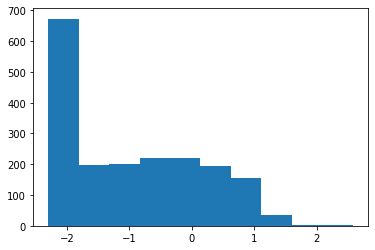

In [17]:
fix, ax = plt.subplots(1)
ax.hist(df_assay['pIC50'])

This isn't normally distrbibuted - therefore, could 'class_weight='balanced' - or, could use tree-based models that perform well on imbalanced datsets as their hierarchcial strucutre alllows them to learn signals from both classses

## Lipinski molecules

This section identifies all molecules that satisfy all criteria of Lipinski's rule of five - for bioavaliable small molecules

* 5 or fewer hydrogen bond donors;
* 10 or fewer hydrogen bond acceptors;
* A molecular weight (MW) of less than 500 Daltons;
* An octanol-water partition coefficient (log $P_{o/w}$) of less than 5. Larger log $P_{o/w}$ means
more lipophilic (i.e., less water soluble).



In [18]:
# Lipinski molecules

def lipinski_mol(df):
    """Determines whether a molecule in dataframe follows Lipinski rules"""
    few_hb_donor = (df["H_donors"] <= 5)
    few_hb_acceptor = (df["H_acceptors"] <= 10)
    low_MW = (df["MW"] < 500)
    low_pc = (df["LogP"] < 5) 
    return (few_hb_acceptor & few_hb_donor & low_MW & low_pc)

def select_lipinski(df, rule = lipinski_mol):
    """Removes compounds from database which don't follow Lipinski rules"""
    df_lip = analyser.analyse_compounds(df, df, 'lipinski_mol', rule)
    # df is passed twice, as it contains the data to operate on, and also is the dataframe to add output to
    df_lip.drop(df_lip[df_lip.lipinski_mol == False].index, inplace=True)
    df_lip.drop(columns = ['lipinski_mol'], inplace=True)  # As all values are now true so column is defunct
    return df_lip

df_lip_compounds = select_lipinski(df_compounds.copy())

print(f"Selected {df_lip_compounds.shape[0]} molecules out of {df_compounds.shape[0]}.")


Selected 1528 molecules out of 2037.


In [19]:
def select_lipinski_assay(df_c, df_a, rule = lipinski_mol):
    """Removes assay corresponding to compounds from database which don't follow Lipinski rules"""
    df_lip = analyser.analyse_compounds(df_c, df_c, 'lipinski_mol', rule)
    df_a['lipinski_mol'] = df_lip['lipinski_mol']
    df_a.drop(df_a[df_a.lipinski_mol == False].index, inplace=True)
    df_a.drop(columns = ['lipinski_mol'], inplace=True)  # As all values are now true so column is defunct
    return df_a

df_lip_assays = select_lipinski_assay(df_compounds.copy(), df_assay.copy())

print(f"Remaining: {df_lip_compounds.shape[0]} assays out of {df_compounds.shape[0]}.")

Remaining: 1528 assays out of 2037.


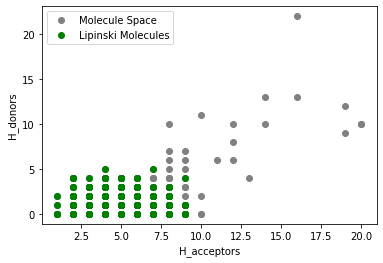

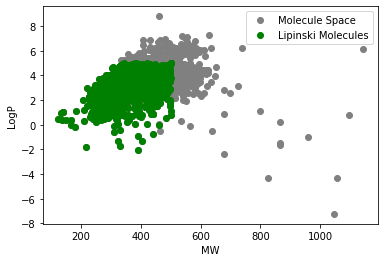

In [20]:
# Representation of Lipinski molecules in sample space

def compare_dataframe_pair(df_1, df_2, x_var, y_var, subset_name = 'Lipinski Molecules'):
    try:
        fig, ax = plt.subplots()
        df_1.plot(x=x_var, y=y_var, ax=ax, style='o', color = 'grey', label = 'Molecule Space')
        df_2.plot(x=x_var, y=y_var, ax=ax, style='o', color = 'g', label = subset_name) 
        ax.set_ylabel(y_var); ax.legend()
    except KeyError as k:
        print(f"Column name {k} does not exist in dataframe")
            

compare_dataframe_pair(df_compounds, df_lip_compounds, 'H_acceptors', 'H_donors')
compare_dataframe_pair(df_compounds, df_lip_compounds, 'MW', 'LogP')

Note that the MW and $P_{o/w}$ are the most significant factors in determining whether a molecule satifes the Lipinski conditions, with the hydrogen bond acceptor and donor limits ruling out very few molecules that have not been ruled out by these factors.

## Relaxed Lipinski conditions

We may also consider the subset of molecules that satisfy at least three of the Lipinski conditions, as shown below:

In [21]:
def relaxed_lipinski(df):
    """Determines whether a molecule in dataframe follows all but one Lipinski rules"""
    few_hb_donor = (df["H_donors"] <= 5) * 1  # (* 1) to convert to int
    few_hb_acceptor = (df["H_acceptors"] <= 10) * 1
    low_MW = (df["MW"] < 500) * 1
    low_pc = (df["LogP"] < 5) * 1
    accepted_cond = few_hb_acceptor + few_hb_donor + low_MW + low_pc
    return (accepted_cond >= 3)

df_rlip_compounds = select_lipinski(df_compounds.copy(), rule=relaxed_lipinski)

print(f"Selected {df_rlip_compounds.shape[0]} molecules out of {df_compounds.shape[0]}.")



Selected 1950 molecules out of 2037.


We see that this new criterion includes a further 422 molecules, compared to the stricter condition where all Lipinski conditions must be passed. We expect from our previous work that most of these new molecules will have broken the MW or $P_{o/w}$ conditions, but may verify this graphically.

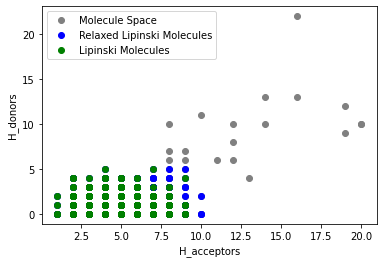

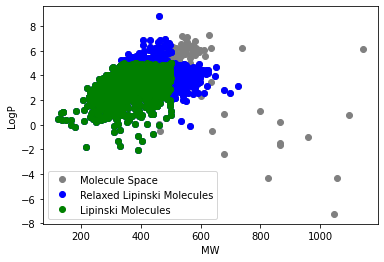

In [22]:
def compare_dataframe_trio(df_1, df_2, df_3, x_var, y_var):
    try:
        fig, ax = plt.subplots()
        df_1.plot(x=x_var, y=y_var, ax=ax, style='o', color = 'grey', label = 'Molecule Space')
        df_2.plot(x=x_var, y=y_var, ax=ax, style='o', color = 'blue', label = 'Relaxed Lipinski Molecules') 
        df_3.plot(x=x_var, y=y_var, ax=ax, style='o', color = 'g', label = 'Lipinski Molecules') 
        ax.set_ylabel(y_var); ax.legend()
    except KeyError as k:
        print(f"Column name {k} does not exist in dataframe")
            

compare_dataframe_trio(df_compounds, df_rlip_compounds, df_lip_compounds, 'H_acceptors', 'H_donors')
compare_dataframe_trio(df_compounds, df_rlip_compounds, df_lip_compounds, 'MW', 'LogP')

As expected, we see two new tranches of molecules (in blue) on the MW/$P_{o/w}$ plot, that have been accepted under the new relaxed conditions. In general, outliers that lie further from the main cluster have not been accepted - these heavier molecules are more likely to fail the hydrogben bond donor/acceptor conditions, as they contain more functional groups. 

We may also consider the distribution of these compounds across subspaces of other assay data:

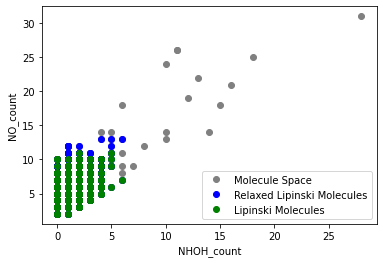

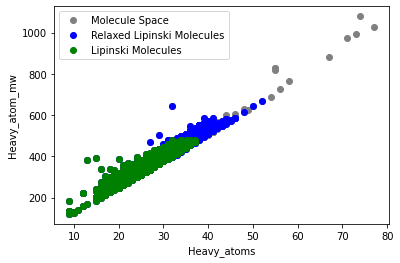

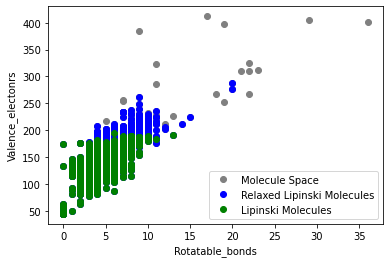

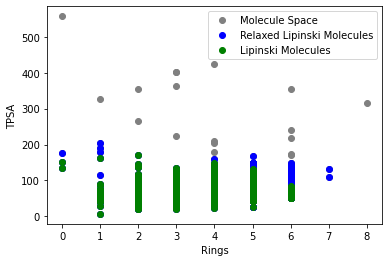

In [23]:
compare_dataframe_trio(df_compounds, df_rlip_compounds, df_lip_compounds, 'NHOH_count', 'NO_count')
compare_dataframe_trio(df_compounds, df_rlip_compounds, df_lip_compounds, 'Heavy_atoms', 'Heavy_atom_mw')
compare_dataframe_trio(df_compounds, df_rlip_compounds, df_lip_compounds, 'Rotatable_bonds', 'Valence_electonrs')
compare_dataframe_trio(df_compounds, df_rlip_compounds, df_lip_compounds, 'Rings', 'TPSA')

#tpsa is good, rings are not - compare tpsa to valence e?
#nhoh is h bond donor, no is hydrogen bond acceptor

In [24]:
print(df_lip_compounds.columns)


Index(['SMILES', 'H_acceptors', 'H_donors', 'MW', 'LogP', 'Heavy_atoms',
       'Heavy_atom_mw', 'NHOH_count', 'NO_count', 'Rotatable_bonds',
       'Valence_electonrs', 'Rings', 'TPSA', 'fingerprint'],
      dtype='object')


## Clustering 

We have computed ECFP (Morgan) fingerprints with radius 2 and 2048 bits for each of the Moonshot compounds. We will then cluster the compounds using the Tanimoto (a.k.a. Jaccard) index. 
The remove zero size clusters?
or remove zero variance bits and conduct pca analysis

In [25]:
#Define clustering setup
def ClusterFps(fps,cutoff=0.2):
    from rdkit import DataStructs
    from rdkit.ML.Cluster import Butina

    # first generate the distance matrix:
    dists = []
    nfps = len(fps)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
        dists.extend([1-x for x in sims])

    # now cluster the data:
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    return cs

In [26]:
clusters=ClusterFps(df_compounds['fingerprint'],cutoff=0.322)  # for 95% confidence that clusters are different


In [27]:
def cluster_size_dist(clusters):
    """ Records the size of each cluster.
    """
    cluster_sizes = []
    for cluster in clusters:
        cluster_sizes.append(len(cluster))
    return cluster_sizes

cluster_size_dist = cluster_size_dist(clusters)
print(f"Generated {len(clusters)} with mean occupancy of {sum(cluster_size_dist)/len(clusters):.2f} molecules")

Generated 911 with mean occupancy of 2.24 molecules


Our clustering algorithm has generated a large number of clusters, with very few molecules per cluster. What does this mean though - are our molecules evenly spread between clusters?

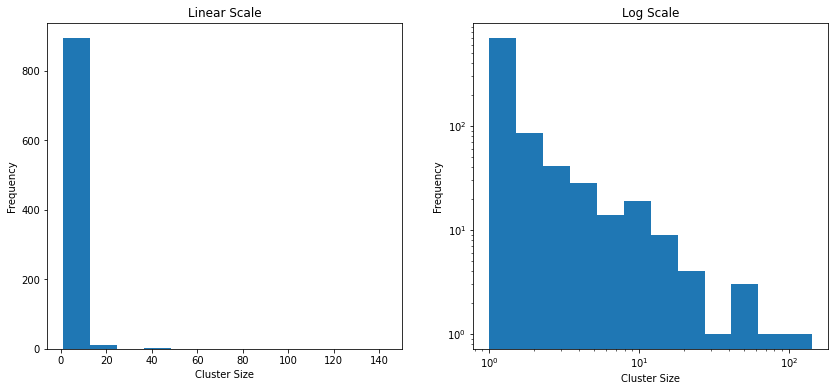

In [28]:
plt.figure(figsize=(14,6))
plt.subplot(121)
hist, bins, _ = plt.hist(cluster_size_dist, bins=12)
plt.xlabel('Cluster Size'); plt.ylabel('Frequency')
plt.title("Linear Scale")

plt.subplot(122)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(cluster_size_dist, bins=logbins)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Cluster Size'); plt.ylabel('Frequency')
plt.title("Log Scale")

plt.show()

From the linear histogram, it is clear that the vast majority of the clusters are small; in fact the log scale shows the frequency of clusters decreases almost exponentially with size. We believe this over-representation of small clusters is a result of an extremely diverse dataset, with many unique molecules unrelated to others in the dataset (and a small number of well clustered molecules, ie derived from the same scaffold).

In [29]:
# find features associated with the most common clusters, and display graphically.
# remove molecules in smallest clusters and recluster?
# or remove zero variance bits in fingerprint and repeat.

In [30]:
def find_max_cluster(clusters):
    """ Returns the largest cluster
    """
    max_cluster = ()
    for cluster in clusters:
        if len(cluster) > len(max_cluster):
            max_cluster = cluster
    return max_cluster

max_cluster = find_max_cluster(clusters)
print(f"The largest cluster has {len(max_cluster)} compounds.")

The largest cluster has 143 compounds.


This cluster can be visualised within the sample space, for example in terms of MD and $P_{o/w}$:

('NHOH_count', 'NO_count')

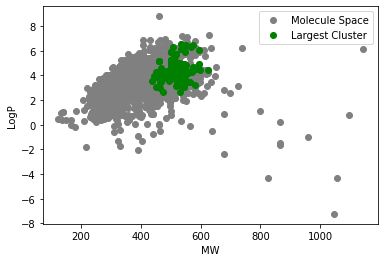

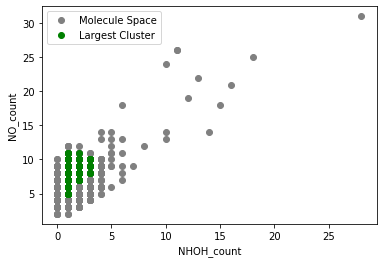

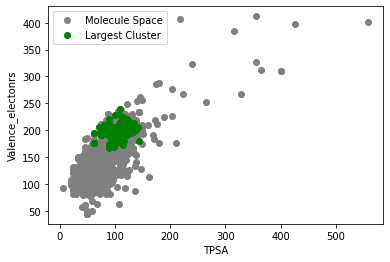

In [31]:
compare_dataframe_pair(df_compounds, df_compounds.iloc[list(max_cluster),], 'MW', 'LogP', subset_name='Largest Cluster')
compare_dataframe_pair(df_compounds, df_compounds.iloc[list(max_cluster),], 'NHOH_count', 'NO_count', subset_name='Largest Cluster')
compare_dataframe_pair(df_compounds, df_compounds.iloc[list(max_cluster),], 'TPSA', 'Valence_electonrs', subset_name='Largest Cluster')

'NHOH_count', 'NO_count'

We may also visualise molecules from the cluster, using RDKit's built-in drawer:

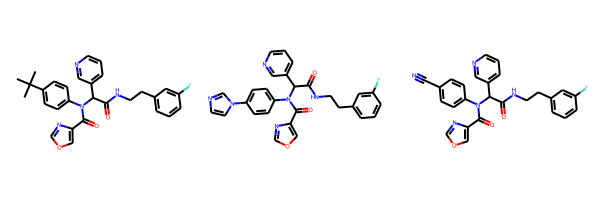

In [32]:
n_molecule = 3
cluster_mols=[]
for i in range(n_molecule):
    m = Chem.MolFromSmiles(df_compounds['SMILES'][max_cluster[i]])
    cluster_mols.append(m)

Draw.MolsToGridImage(cluster_mols)


Here we can see a consistent molecular scafold, with different functional groups on the right hand side of the molecule.

# Machine Learning Models

In [33]:
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix
from analysis_methods import AnalysisMethods
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
from analysis_methods import AnalysisMethods

In [34]:
data_array = df_lip_compounds[df_lip_compounds.columns[1:-1].to_numpy()]

df_lip_assays['Active'] = AnalysisMethods.IC50_threshold(df_lip_assays)

hot_encodes = []
for i in df_lip_assays['Active']:
    if i == True:
        hot_encodes.append(1)
    else:
        hot_encodes.append(0)
df_lip_assays['Hot_Activity'] = hot_encodes

df_lip_assays['Hot_Activity'].value_counts(1)

0    0.509817
1    0.490183
Name: Hot_Activity, dtype: float64

## Logistic Regression

In [35]:
#create logistic regression pipeline with preprocessing (scaler and C)
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', LogisticRegression(max_iter=10000))])
#generate parameter grid with preprocesssing and classifier parameters
param_grid = {'preprocessing':[StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'classifier__C': [0.0001, 0.001, 0.01, 1, 10, 100]}

#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_array, df_lip_assays['Hot_Activity'], 
                                                        random_state=0)

### 1) Grid Search for best performing preprocessing and parameters for Accuracy

In [36]:
kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=kfold_shuffle)
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best esimator: /n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ',
        accuracy_score(y_test, grid_kfold_shuffle.predict(X_test)), '\n')

grid_kfold_shuffle: best esimator: /n Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier', LogisticRegression(C=100, max_iter=10000))])
grid_kfold_shuffle: best cross-validation score:  0.7085817353332067
grid_kfold_shuffle: test set average accuracy:  0.7303664921465969 



### 2) Grid Search for best performing preprocessing and parameters fo average precision score

In [37]:
kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=kfold_shuffle, scoring='average_precision')
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best esimator: /n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle test set average precision: ', 
       average_precision_score(y_test, grid_kfold_shuffle.decision_function(X_test)), '\n')

grid_kfold_shuffle: best esimator: /n Pipeline(steps=[('preprocessing', None),
                ('classifier', LogisticRegression(C=10, max_iter=10000))])
grid_kfold_shuffle: best cross-validation score:  0.7251487572113545
grid_kfold_shuffle test set average precision:  0.7266156053219259 



### 3) Grid Search for best performing preprocessing and parameters for ROC AUC

In [38]:
#Grid search with with shuffled kfold cross validation
#use decision function to calculate AUC
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=kfold_shuffle, scoring='roc_auc')
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set AUC: ', 
       roc_auc_score(y_test, grid_kfold_shuffle.decision_function(X_test)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', None),
                ('classifier', LogisticRegression(C=100, max_iter=10000))])
grid_kfold_shuffle: best cross-validation score:  0.7541549404404295
grid_kfold_shuffle test set AUC:  0.7878700420549186 



### 4) Generate precision-recall cruve with best parameters for average precision

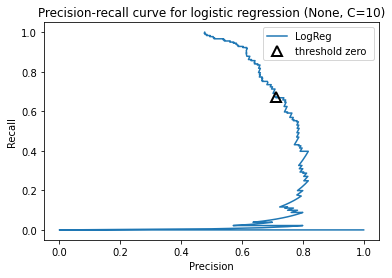

In [39]:
pipe = Pipeline([('preprocessing', None), 
                 ('classifier', LogisticRegression(C=10, max_iter=10000))])
X_train, X_test, y_train, y_test = train_test_split(data_array, df_lip_assays['Hot_Activity'], random_state=0)
pipe.fit(X_train, y_train)
predict = (pipe.decision_function(X_test))

precision, recall, thresholds = precision_recall_curve(y_test, predict)

plt.plot(precision, recall, label='LogReg')
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], '^', c='k', 
          markersize=10, label='threshold zero ', fillstyle='none', mew=2)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(loc='best')
plt.title('Precision-recall curve for logistic regression (None, C=10)')
plt.savefig('Precision_recall_LR_binary.png', bbox_inches='tight')

### 5) Generate ROC curve with best parameters for ROC AUC

Text(0.5, 1.0, 'ROC curve for logistic regression (None, C=100)')

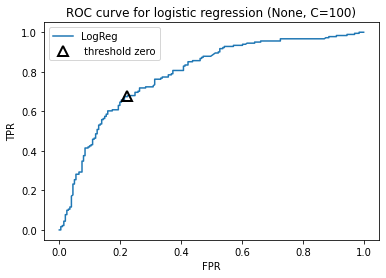

In [40]:
#use best preprocessing (None) and parameters (c=1) for av. precision

pipe = Pipeline([('preprocessing', None), 
                 ('classifier', LogisticRegression(C=100, max_iter=10000))])
X_train, X_test, y_train, y_test = train_test_split(data_array, df_lip_assays['Hot_Activity'], random_state=0)
pipe.fit(X_train, y_train)
predict = (pipe.decision_function(X_test))

fpr, tpr, thresholds = roc_curve(y_test, pipe.decision_function(X_test))

plt.plot(fpr, tpr, label='LogReg')
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], '^', c='k',
         markersize=10, label=' threshold zero', fillstyle='none', mew=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='best')
plt.title('ROC curve for logistic regression (None, C=100)')

### 7) Generate Confusion matrix with best parameters for average accuracy

**Precision/sens/spec/fpr:**   

precision = PPV = TP/TP+FP   
sensitivity = recall = TPR = TP/TP+FN   
specificity = TNR = TN/TN+FP   
FPR = FP/FP+TN = (1-specificity)   

In [79]:
#confusion matrix (StandardSclaer, C=100)

#build and fit pipieline
pipe = Pipeline([('preprocessing', StandardScaler()), 
                 ('classifier', LogisticRegression(C=100, max_iter=10000))])
X_train, X_test, y_train, y_test = train_test_split(data_array, df_lip_assays['Hot_Activity'], random_state=0)


In [80]:
pipe.fit(X_train, y_train)
predict = pipe.predict(X_test).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test, predict)

#calculate precision, sensitivity, specifcity, FPR, erros
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test[y_test==0].count())*100
major_error = (confusion[1][0]/y_test[y_test==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)


Precision:  0.7349397590361446
Sensitivity:  0.6740331491712708
Specificity:  0.7810945273631841
FPR : 0.21890547263681592
very major error : 21.890547263681594
major error:  32.59668508287293

 confusion matrix: 
 [[157  44]
 [ 59 122]]


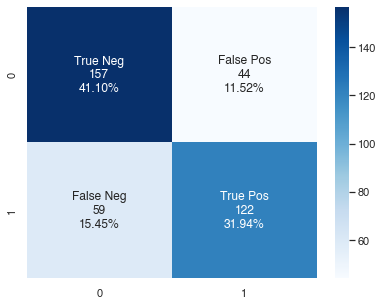

In [81]:
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Helvetica'})

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion.flatten()/np.sum(confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize = (6.5,5))
sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')
plt.savefig('LR_binary_cf.png', bbox_inches='tight')

## Single Decision Tree

### 1) Grid search for best performing preprocessing and parameters for ACCURACY

In [44]:
tree = DecisionTreeClassifier(random_state=0)
param_grid = {'max_depth':[2,4,6,8,10,12,14, None], 
              'min_samples_split':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
              'min_samples_leaf':[0.1,0.2,0.3,0.4,0.5],
              'max_features':['auto','sqrt','log2', None]}
X_train, X_test, y_train, y_test = train_test_split(data_array, df_lip_assays['Hot_Activity'],
                                                    random_state=0)

In [45]:
#Grid search with shuffled kfold validation
Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(tree, param_grid, cv=Kfold_shuffle)
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test, grid_kfold_shuffle.predict(X_test)), '\n')

grid_kfold_shuffle: best estimator: 
 DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.6693070058857035
grid_kfold_shuffle: test set average accuracy:  0.6649214659685864 



### 2) Generate Feature importance plot and visualise decision tree

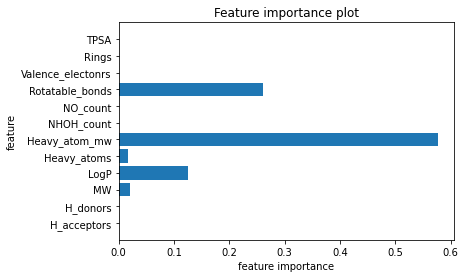

In [57]:
#define trees with best perfoming parameters
tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1,
                       min_samples_split=0.1, random_state=0)
tree.fit(X_train, y_train)    

#plot charts
def plot_feature_importances(model):
    n_features = data_array.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df_lip_compounds.columns[1:-1])
    plt.xlabel('feature importance')
    plt.ylabel('feature')
    plt.ylim(-1, n_features)
    plt.title('Feature importance plot')

plot_feature_importances(tree)


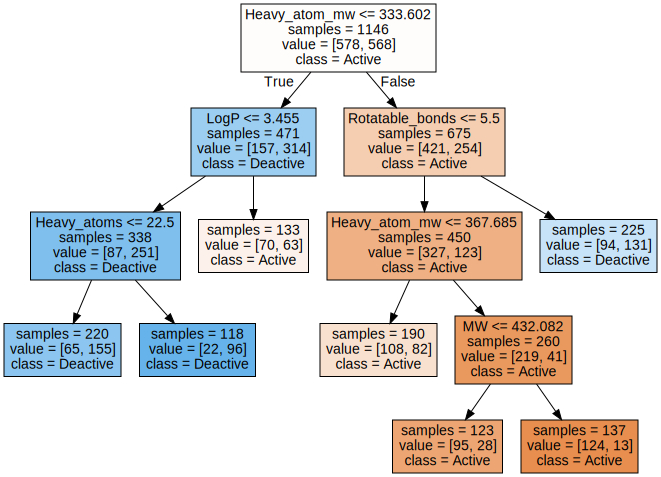

In [58]:
export_graphviz(tree, out_file="tree.dot", class_names=['Active', 'Deactive'],
    feature_names=df_lip_compounds.columns[1:-1], impurity=False, filled=True)

with open('tree.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### 3) Grid search for best performing parameters for AVERAGE PRECISION SCORE

In [51]:
#Grid search with shuffled kfold validation
#use predict_proba function to calculate average_precision
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(tree, param_grid, cv=kfold_shuffle, scoring='average_precision')
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set average precision: ', 
       average_precision_score(y_test, grid_kfold_shuffle.predict_proba(X_test)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.6615699300996729
grid_kfold_shuffle test set average precision:  0.6909149186005005 



### 4) Grid search for best performing preprocessing and parameters for ROC AUC

In [52]:
#Grid search with shuffled kfold validation
#use predict_proba function to calculate average_precision

kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(tree, param_grid, cv=kfold_shuffle, scoring='roc_auc')
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set AUC: ', 
       roc_auc_score(y_test, grid_kfold_shuffle.predict_proba(X_test)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.7215177343336754
grid_kfold_shuffle test set AUC:  0.744385805777741 



### 5) Generate precision-recall curve with best parameters for average precision

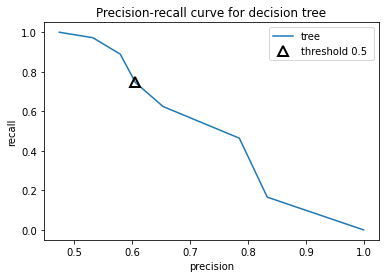

In [61]:
X_train, X_test, y_train, y_test = train_test_split(data_array, df_lip_assays['Hot_Activity'], random_state=0)
tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
tree.fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(y_test, tree.predict_proba(X_test)[:, 1])

plt.plot(precision, recall, label='tree')
close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[close_default], recall[close_default], '^', c='k', 
          markersize=10, label='threshold 0.5 ', fillstyle='none', mew=2)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Precision-recall curve for decision tree')
plt.legend(loc='best')

### 6) Generate ROC curve with best parameters for ROC AUC

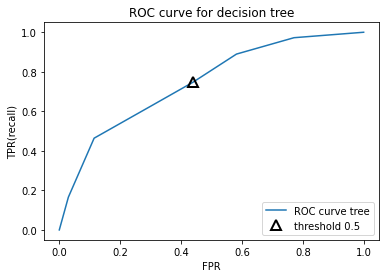

In [62]:
fpr, tpr, thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label='ROC curve tree')
plt.xlabel('FPR')
plt.ylabel('TPR(recall)')

close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[close_default], tpr[close_default], '^', markersize=10, label='threshold 0.5', 
         fillstyle='none', c='k', mew=2)
plt.title('ROC curve for decision tree')
plt.legend(loc=4)

### 7) Generate confusion matrix with best parameters (average precision)

In [63]:
#confusion matrix (max_features=auto, max_depth=2, min_samples_lieaf=0.1, min_samples_split = 0)   

#build and fit decision tree
X_train, X_test, y_train, y_test = train_test_split(data_array, df_lip_assays['Hot_Activity'], random_state=0)
tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
tree.fit(X_train, y_train)
predict = tree.predict(X_test).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test, predict)

#calculate precision, sensitivty, specificity, FPR, errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test[y_test==0].count())*100
major_error = (confusion[1][0]/y_test[y_test==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.653179190751445
Sensitivity:  0.6243093922651933
Specificity:  0.7014925373134329
FPR : 0.29850746268656714
very major error : 29.850746268656714
major error:  37.569060773480665

 confusion matrix: 
 [[141  60]
 [ 68 113]]


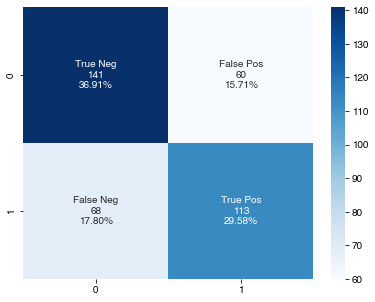

In [64]:
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Helvetica'})

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion.flatten()/np.sum(confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize = (6.5,5))
sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')
plt.savefig('tree_binary_cf.png', bbox_inches='tight')

## Random Forest Model

In [65]:
forest = RandomForestClassifier(n_jobs=-1, random_state=0)



param_grid = {'n_estimators':[10,20,30,40,50,60,100],
              'max_depth':[2,4,6,8,10,12,14,16]}
X_train, X_test, y_train, y_test = train_test_split(data_array, df_lip_assays['Hot_Activity'],
                                                    random_state=0)

### 1) Grid search for best performing preprocessing and parameters for ACCURACY

In [66]:
#grid search with shuffled kfold validation
KFold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=KFold_shuffle)
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test, grid_kfold_shuffle.predict(X_test)), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.7295158534269983
grid_kfold_shuffle: test set average accuracy:  0.7486910994764397 



### 2) Grid search for best performing parameters for AVERAGE PRECISION SCORE

In [67]:
#grid search with shuffled kfold validation
#use predict_proba function to calculate average_precision
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=kfold_shuffle, scoring='average_precision')
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set average precision: ', 
       average_precision_score(y_test, grid_kfold_shuffle.predict_proba(X_test)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.7790923060747478
grid_kfold_shuffle test set average precision:  0.7849191331781898 



### 3) Grid search for best performing preprocessing and parameters for ROC AUC

In [68]:
#grid search with shuffled kfold validation
#use predict_prob a function ot calculate ROC AUC

kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=kfold_shuffle, scoring='roc_auc')
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set AUC: ', 
       roc_auc_score(y_test, grid_kfold_shuffle.predict_proba(X_test)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.7844481091827296
grid_kfold_shuffle test set AUC:  0.8099420026937136 



### 4) Generate feature importance plots and visualise a tree from the forest

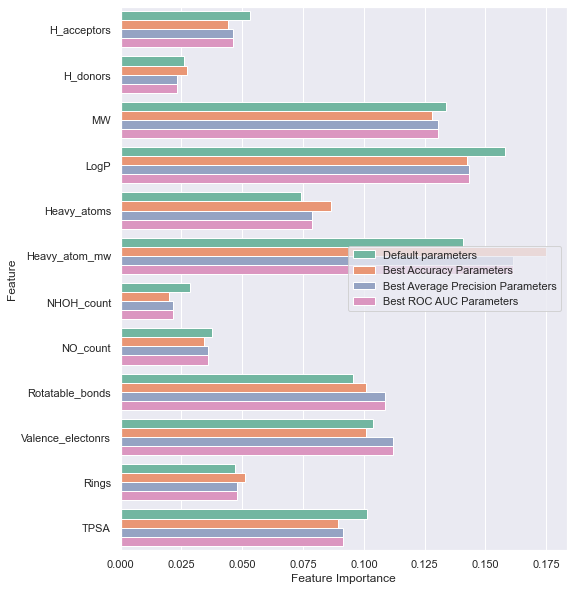

In [72]:
X_train, X_test, y_train, y_test = train_test_split(data_array, df_lip_assays['Hot_Activity'], random_state=0)

accuracy_params = RandomForestClassifier(max_depth=8, n_estimators=50, n_jobs=-1, random_state=0)
precision_params = RandomForestClassifier(max_depth=8, n_estimators=100, n_jobs=-1, random_state=0)
ROC_AUC_params = RandomForestClassifier(max_depth=8, n_estimators=100, n_jobs=-1, random_state=0)
forest_no_params = RandomForestClassifier(random_state=0)
accuracy_params.fit(X_train, y_train)
precision_params.fit(X_train, y_train)
ROC_AUC_params.fit(X_train, y_train)
forest_no_params.fit(X_train, y_train)

DF = pd.DataFrame({'Default parameters':forest_no_params.feature_importances_,
                   'Best Accuracy Parameters':accuracy_params.feature_importances_,
                   'Best Average Precision Parameters': precision_params.feature_importances_,
                   'Best ROC AUC Parameters': ROC_AUC_params.feature_importances_,
                   'n_features':np.arange(data_array.shape[1])})

df_melted = DF.melt("n_features",var_name="Params",value_name="importance")

sns.set_theme()
sns.set(rc={'figure.figsize':(8,10)})
sns.set_palette(sns.color_palette('Set2'))
x = sns.barplot(data=df_melted, x='importance', y='n_features', hue='Params', orient='h', alpha=1)
plt.yticks(DF['n_features'], df_lip_compounds.columns[1:-1])
x.set(xlabel='Feature Importance', ylabel='Feature')
plt.legend(loc='center right')

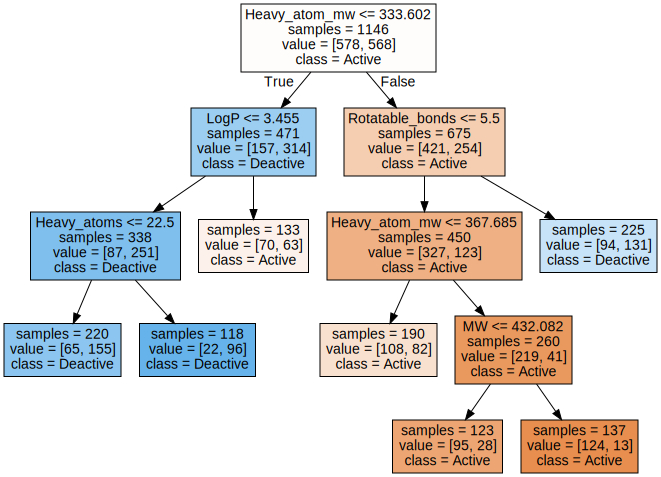

In [84]:
estimator = accuracy_params.estimators_[30]

export_graphviz(tree, out_file="tree.dot", class_names=['Active', 'Deactive'],
    feature_names=df_lip_compounds.columns[1:-1], impurity=False, filled=True)

with open('tree.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))


### 5) Generate precision-recall curve with best parameters for average precision

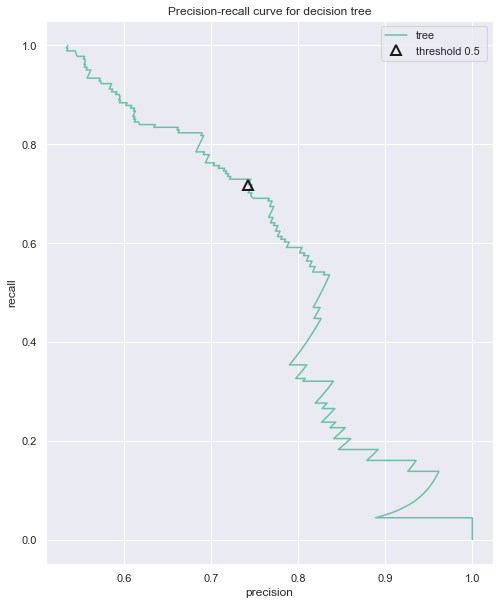

In [75]:
#precision recall curve for best average precision estimator

X_train, X_test, y_train, y_test = train_test_split(data_array, df_lip_assays['Hot_Activity'], random_state=0)
forest = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(y_test, forest.predict_proba(X_test)[:, 1])

plt.plot(precision, recall, label='tree')
close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[close_default], recall[close_default], '^', c='k', 
          markersize=10, label='threshold 0.5 ', fillstyle='none', mew=2)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Precision-recall curve for decision tree')
plt.legend(loc='best')

### 6) Generate ROC curve with best parameters for ROC AUC

Text(0.5, 1.0, 'ROC curve for random forest')

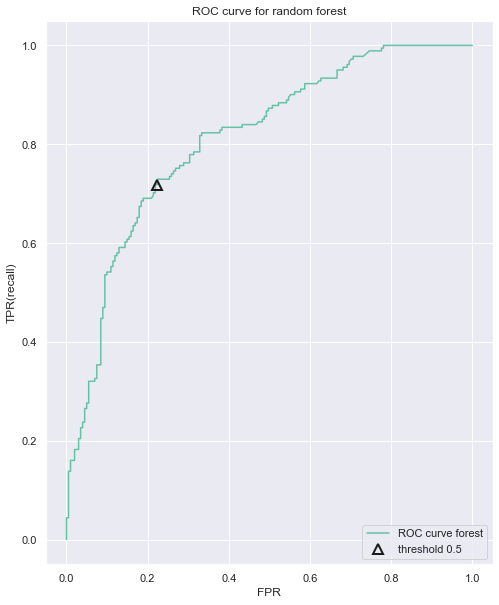

In [76]:
forest = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

fpr, tpr, thresholds = roc_curve(y_test, forest.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label='ROC curve forest')
plt.xlabel('FPR')
plt.ylabel('TPR(recall)')
close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[close_default], tpr[close_default], '^', markersize=10, label='threshold 0.5', 
         fillstyle='none', c='k', mew=2)
plt.legend(loc=4)
plt.title('ROC curve for random forest')

### 7) Generate confusion matrix with best parameters for average precision and ROC AUC


In [77]:

X_train, X_test, y_train, y_test = train_test_split(data_array, df_lip_assays['Hot_Activity'], random_state=0)
forest = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=0)
forest.fit(X_train, y_train)
predict = forest.predict(X_test).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test, predict)

#calculate precision, sensitivity, specficity, FPR, errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test[y_test==0].count())*100
major_error = (confusion[1][0]/y_test[y_test==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.7428571428571429
Sensitivity:  0.7182320441988951
Specificity:  0.7761194029850746
FPR : 0.22388059701492535
very major error : 22.388059701492537
major error:  28.176795580110497

 confusion matrix: 
 [[156  45]
 [ 51 130]]


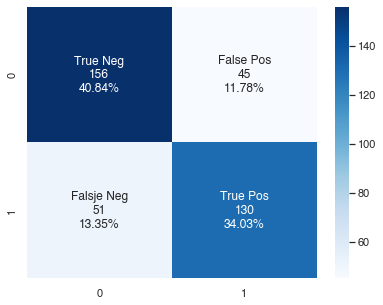

In [78]:
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Helvetica'})

group_names = ['True Neg','False Pos','Falsje Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion.flatten()/np.sum(confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize = (6.5,5))
sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')
plt.savefig('forest_binary_cf.png', bbox_inches='tight')